# Data preparation

- TODO: visualisation of Train Loss and Validate Loss => done
- TODO: table, maybe?

## Define and read files needed from datasets

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Countries lookup table
lookup_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")
# yield and production data
yield_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Yield_and_Production_data.csv")
# land cover data
land_cover_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Land_Cover_Percent_data.csv")
# define files to merge
climate_files = {
    "rain": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv",
    "snow": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Snowf_tavg_data.csv",
    "esoil": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/ESoil_tavg_data.csv",
    "soilmoisture_0_10": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi0_10cm_inst_data.csv",
    "soilmoisture_10_40": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi10_40cm_inst_data.csv",
    "soilmoisture_40_100": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi40_100cm_inst_data.csv",
    "soilmoisture_100_200": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi100_200cm_inst_data.csv",
    "soiltemp_0_10": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP0_10cm_inst_data.csv",
    "soiltemp_10_40": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP10_40cm_inst_data.csv",
    "soiltemp_40_100": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP40_100cm_inst_data.csv",
    "soiltemp_100_200": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP100_200cm_inst_data.csv",
    "tveg": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/TVeg_tavg_data.csv",
    "tws": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/TWS_inst_data.csv",
    "canopint": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/CanopInt_inst_data.csv"  # Newly added dataset
}

## Spatial join and merge datasets

In [2]:
# Helper Function: process and average by country-year
def process_monthly_climate(filepath, variable_prefix, lookup_gdf):
    df = pd.read_csv(filepath)
    # Convert lat/lon into Shapely Points
    df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    # Make GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    # Reproject to metric system for distance calculation
    gdf_proj = gdf.to_crs("EPSG:3857")
    lookup_proj = lookup_gdf.to_crs("EPSG:3857")
    # Spatial join to match each climate point to its nearest country lookup point
    joined = gpd.sjoin_nearest(gdf_proj, lookup_proj, how='left', distance_col='distance')
    # Drop geometry and return to original lat/lon projection
    joined = joined.to_crs("EPSG:4326").drop(columns='geometry')
    # Identify monthly columns (e.g. month_1 to month_12)
    month_cols = [col for col in df.columns if 'month' in col.lower()]
    # Rename them to include the variable prefix (e.g. rain_1, rain_2, ...)
    new_col_map = {col: f"{variable_prefix}_{i+1}" for i, col in enumerate(month_cols)}
    joined = joined.rename(columns=new_col_map)
    # Group by country + year and take the mean across all nearby points
    monthly_avg = joined.groupby(['country', 'year'])[[*new_col_map.values()]].mean().reset_index()
    return monthly_avg

lookup_df['geometry'] = [Point(xy) for xy in zip(lookup_df['longitude'], lookup_df['latitude'])]
lookup_gdf = gpd.GeoDataFrame(lookup_df, geometry='geometry', crs='EPSG:4326')
# lowercase column names
yield_df.columns = [c.strip().lower() for c in yield_df.columns]
# filter to only 'Yield' rows
yield_df = yield_df[yield_df["element"] == "Yield"]
# rename 'value' to 'yield'
if "yield" not in yield_df.columns and "value" in yield_df.columns:
    yield_df = yield_df.rename(columns={"value": "yield"})

# Process and merge all climate datasets
merged_climate = None
for prefix, path in climate_files.items():
    climate_df = process_monthly_climate(path, prefix, lookup_gdf)
    if merged_climate is None:
        merged_climate = climate_df
    else:
        # Outer join to accumulate all monthly features
        merged_climate = pd.merge(merged_climate, climate_df, on=["country", "year"], how="outer")

land_cover_df['geometry'] = [Point(xy) for xy in zip(land_cover_df['longitude'], land_cover_df['latitude'])]
land_cover_gdf = gpd.GeoDataFrame(land_cover_df, geometry='geometry', crs='EPSG:4326')
# Join each land cover point to nearest country point
land_cov_joined = gpd.sjoin_nearest(land_cover_gdf.to_crs("EPSG:3857"), lookup_gdf.to_crs("EPSG:3857"), how='left')
land_cov_joined = land_cov_joined.to_crs("EPSG:4326").drop(columns='geometry')
# Rename land cover class columns to standardized names
land_class_cols = [col for col in land_cover_df.columns if "class_" in col.lower()]
land_cov_col_map = {col: f"mean_cov_{col.split('_')[-1]}" for col in land_class_cols}
land_cov_joined = land_cov_joined.rename(columns=land_cov_col_map)
# Aggregate land cover by country (mean percent per class)
land_cov_summary = land_cov_joined.groupby("country")[list(land_cov_col_map.values())].mean().reset_index()

# Merge with climate on country + year
climate_with_land = pd.merge(merged_climate, land_cov_summary, on="country", how="left")

# Merge with yield data 
final_df = pd.merge(yield_df, climate_with_land, on=["country", "year"], how="inner")

# # Organize column order
# def ordered_columns(final_df):
#     rain_cols = [f"rain_{i}" for i in range(1, 13)]
#     snow_cols = [f"snow_{i}" for i in range(1, 13)]
#     esoil_cols = [f"esoil_{i}" for i in range(1, 13)]
#     soilm_cols, soilt_cols = [], []
#     for layer in ["0_10", "10_40", "40_100", "100_200"]:
#         soilm_cols += [f"soilmoisture_{layer}_{i}" for i in range(1, 13)]
#         soilt_cols += [f"soiltemp_{layer}_{i}" for i in range(1, 13)]

#     tveg_cols = [f"tveg_{i}" for i in range(1, 13)]
#     tws_cols = [f"tws_{i}" for i in range(1, 13)]
#     canopint_cols = [f"canopint_{i}" for i in range(1, 13)]
#     landcov_cols = [f"mean_cov_{i}" for i in range(1, 18)]

#     base_cols = ["country", "item", "year"]
#     # Combine all expected features (filter only those that exist in the final DataFrame)
#     all_features = landcov_cols + rain_cols + snow_cols + esoil_cols + soilm_cols + soilt_cols + tveg_cols + tws_cols + canopint_cols
#     all_features = [col for col in all_features if col in final_df.columns]

#     return base_cols + all_features + ["yield"]

def ordered_columns(final_df):
    base_cols = ["country", "item", "year"]
    landcov_cols = [f"mean_cov_{i}" for i in range(1, 18)]

    def monthly_block(prefix):
        # 12 monthly columns
        months = [f"{prefix}_{i}" for i in range(1, 13)]
        # Corresponding summary columns
        summaries = [f"{prefix}_{stat}" for stat in ['mean', 'std', 'min', 'max']]
        # Include only those that exist in the DataFrame
        return [col for col in months + summaries if col in final_df.columns]

    feature_blocks = []

    # Add monthly + summary blocks for each
    prefixes = [
        "rain", "snow", "esoil",
        "soilmoisture_0_10", "soilmoisture_10_40", "soilmoisture_40_100", "soilmoisture_100_200",
        "soiltemp_0_10", "soiltemp_10_40", "soiltemp_40_100", "soiltemp_100_200",
        "tveg", "tws", "canopint"
    ]

    for prefix in prefixes:
        feature_blocks.extend(monthly_block(prefix))

    # Final ordered list
    all_features = landcov_cols + feature_blocks
    all_features = [col for col in all_features if col in final_df.columns]

    return base_cols + all_features + ["yield"]




# Adding summary
# Function to add summary stats for 12-month feature groups
def add_monthly_summary_features(df, feature_prefixes):
    for prefix in feature_prefixes:
        month_cols = [f"{prefix}_{i}" for i in range(1, 13) if f"{prefix}_{i}" in df.columns]
        if len(month_cols) == 12:  # only compute if all 12 months are present
            df[f"{prefix}_mean"] = df[month_cols].mean(axis=1)
            df[f"{prefix}_std"] = df[month_cols].std(axis=1)
            df[f"{prefix}_min"] = df[month_cols].min(axis=1)
            df[f"{prefix}_max"] = df[month_cols].max(axis=1)
    return df

monthly_prefixes = [
    "rain", "snow", "esoil",
    "soilmoisture_0_10", "soilmoisture_10_40", "soilmoisture_40_100", "soilmoisture_100_200",
    "soiltemp_0_10", "soiltemp_10_40", "soiltemp_40_100", "soiltemp_100_200",
    "tveg", "tws", "canopint"
]

final_df = add_monthly_summary_features(final_df, monthly_prefixes)

# # Update output column list
# summary_cols = [col for col in final_df.columns if any(stat in col for stat in ["_mean", "_std", "_min", "_max"])]
# final_df = final_df[ordered_columns(final_df) + summary_cols]

final_df = final_df[ordered_columns(final_df)]

# Save final output
final_df.to_csv("Core_Dataset.csv", index=False)
print("Core dataset saved as Core_Dataset.csv")

Core dataset saved as Core_Dataset.csv


# Data preprocessing

## Data shaping

In [3]:
# Load data
df = pd.read_csv("Core_Dataset.csv")

# Move 'year' to the front
cols = df.columns.tolist()
if 'year' in cols:
    cols.insert(0, cols.pop(cols.index('year')))
df = df[cols]

# Display structure
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (67963, 245)
Columns: ['year', 'country', 'item', 'mean_cov_1', 'mean_cov_2', 'mean_cov_3', 'mean_cov_4', 'mean_cov_5', 'mean_cov_6', 'mean_cov_7', 'mean_cov_8', 'mean_cov_9', 'mean_cov_10', 'mean_cov_11', 'mean_cov_12', 'mean_cov_13', 'mean_cov_14', 'mean_cov_15', 'mean_cov_16', 'mean_cov_17', 'rain_1', 'rain_2', 'rain_3', 'rain_4', 'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'rain_10', 'rain_11', 'rain_12', 'rain_mean', 'rain_std', 'rain_min', 'rain_max', 'snow_1', 'snow_2', 'snow_3', 'snow_4', 'snow_5', 'snow_6', 'snow_7', 'snow_8', 'snow_9', 'snow_10', 'snow_11', 'snow_12', 'snow_mean', 'snow_std', 'snow_min', 'snow_max', 'esoil_1', 'esoil_2', 'esoil_3', 'esoil_4', 'esoil_5', 'esoil_6', 'esoil_7', 'esoil_8', 'esoil_9', 'esoil_10', 'esoil_11', 'esoil_12', 'esoil_mean', 'esoil_std', 'esoil_min', 'esoil_max', 'soilmoisture_0_10_1', 'soilmoisture_0_10_2', 'soilmoisture_0_10_3', 'soilmoisture_0_10_4', 'soilmoisture_0_10_5', 'soilmoisture_0_10_6', 'soilmoisture_0_10_7',

In [4]:
# Convert year to integer format (e.g. 2010, 2011, ...)
df['year_raw'] = df['year'].astype(int)  # backup for clean export
# Optional sanity check
print("Years in dataset:", sorted(df['year'].unique()))

Years in dataset: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


In [5]:
# Shift yield by -1 to make next year's yield the prediction target
df = df.sort_values(['country', 'item', 'year_raw'])  # ensure proper chronological order
df['target'] = df.groupby(['country', 'item'])['yield'].shift(-1)

# Drop rows where target is missing (i.e., last year of each country/item group)
df = df.dropna(subset=['target']).copy()

In [6]:
def time_aware_split(df, test_year, val_year):
    train_list, val_list, test_list = [], [], []

    for _, group in df.groupby(['country', 'item']):
        group = group.sort_values('year_raw')
        train = group[group['year_raw'] < val_year]
        val = group[group['year_raw'] == val_year]
        test = group[group['year_raw'] == test_year]
        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    return pd.concat(train_list).reset_index(drop=True), \
           pd.concat(val_list).reset_index(drop=True), \
           pd.concat(test_list).reset_index(drop=True)

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode country
country_encoder = LabelEncoder()
df['country_id'] = country_encoder.fit_transform(df['country'])
num_countries = df['country_id'].nunique()

In [8]:
# Encode year as categorical ID for embedding
year_encoder = LabelEncoder()
df['year_id'] = year_encoder.fit_transform(df['year_raw'])  # not year+1, just original year
num_years = df['year_id'].nunique()

In [9]:
train_df, val_df, test_df = time_aware_split(df, test_year=2021, val_year=2020)
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (52163, 249)
Val: (5166, 249)
Test: (5169, 249)


In [10]:
# One-hot encode 'item'
df = pd.get_dummies(df, columns=['item'], prefix='item')
item_onehot_cols = [col for col in df.columns if col.startswith('item_')]

In [11]:
print("Encoded Sample:")
print(df[['country', 'country_id', 'year_raw', 'year_id']].drop_duplicates().sort_values('year_raw').head())

print(f"Total countries: {num_countries}")
print(f"Total years: {num_years}")
print(f"One-hot item columns: {item_onehot_cols}")

Encoded Sample:
           country  country_id  year_raw  year_id
0      Afghanistan           0      2010        0
40411      Morocco         100      2010        0
58993     Thailand         145      2010        0
17395      Czechia          40      2010        0
41204   Mozambique         101      2010        0
Total countries: 165
Total years: 12
One-hot item columns: ['item_Abaca, manila hemp, raw', 'item_Agave fibres, raw, n.e.c.', 'item_Apples', 'item_Apricots', 'item_Avocados', 'item_Bambara beans, dry', 'item_Bananas', 'item_Barley', 'item_Beans, dry', 'item_Blueberries', 'item_Broad beans and horse beans, dry', 'item_Buckwheat', 'item_Canary seed', 'item_Cantaloupes and other melons', 'item_Cashewapple', 'item_Castor oil seeds', 'item_Cereals n.e.c.', 'item_Cherries', 'item_Chick peas, dry', 'item_Coconuts, in shell', 'item_Cow peas, dry', 'item_Cranberries', 'item_Currants', 'item_Dates', 'item_Figs', 'item_Flax, raw or retted', 'item_Fonio', 'item_Gooseberries', 'item_Grape

In [12]:
item_onehot_cols = [col for col in df.columns if col.startswith('item_')]

# Re-add any missing one-hot columns in val/test with zeros
for col in item_onehot_cols:
    for dset in [df]:
        if col not in dset.columns:
            dset[col] = 0

# Columns to exclude from scaling
exclude = ['yield', 'target', 'country', 'country_id', 'year_raw', 'year_id']
exclude += item_onehot_cols  # exclude one-hot item columns too

# Features to scale (everything else)
feature_cols = [col for col in df.columns if col not in exclude]


Normalise

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit only on train
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# Transform val and test
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

Scale the Target Separately

In [14]:
target_scaler = MinMaxScaler()

train_df['target_scaled'] = target_scaler.fit_transform(train_df[['target']])
val_df['target_scaled'] = target_scaler.transform(val_df[['target']])
test_df['target_scaled'] = target_scaler.transform(test_df[['target']])

/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/4136113568.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['target_scaled'] = target_scaler.fit_transform(train_df[['target']])
/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/4136113568.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_df['target_scaled'] = target_scaler.transform(val_df[['target']])
/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/4136113568.py:5: PerformanceWarning: DataFrame is highly fragment

 Fill any NaNs (if any exist after merge)

In [15]:
train_df[feature_cols] = train_df[feature_cols].fillna(train_df[feature_cols].mean())
val_df[feature_cols] = val_df[feature_cols].fillna(train_df[feature_cols].mean())  # use train stats
test_df[feature_cols] = test_df[feature_cols].fillna(train_df[feature_cols].mean())

In [16]:
print("Feature sample after scaling:")
print(train_df[feature_cols].head())
print("Target range (train):", train_df['target_scaled'].min(), train_df['target_scaled'].max())

Feature sample after scaling:
       year  mean_cov_1  mean_cov_2  mean_cov_3  mean_cov_4  mean_cov_5  \
0  0.000000         1.0         0.0         0.0         0.0         0.0   
1  0.111111         1.0         0.0         0.0         0.0         0.0   
2  0.222222         1.0         0.0         0.0         0.0         0.0   
3  0.333333         1.0         0.0         0.0         0.0         0.0   
4  0.444444         1.0         0.0         0.0         0.0         0.0   

   mean_cov_6  mean_cov_7  mean_cov_8  mean_cov_9  ...  canopint_7  \
0         0.0         0.0         0.0         0.0  ...    0.013346   
1         0.0         0.0         0.0         0.0  ...    0.014067   
2         0.0         0.0         0.0         0.0  ...    0.015859   
3         0.0         0.0         0.0         0.0  ...    0.010501   
4         0.0         0.0         0.0         0.0  ...    0.015142   

   canopint_8  canopint_9  canopint_10  canopint_11  canopint_12  \
0    0.023366    0.018008     

In [17]:
feature_cols += item_onehot_cols  # include one-hot columns last (will not scale them)

In [18]:
# 1. One-hot encode 'item' again, now in each split
train_df = pd.get_dummies(train_df, columns=['item'], prefix='item')
val_df = pd.get_dummies(val_df, columns=['item'], prefix='item')
test_df = pd.get_dummies(test_df, columns=['item'], prefix='item')

# 2. Ensure all splits have the same item_* columns
all_item_cols = sorted(set(train_df.columns) | set(val_df.columns) | set(test_df.columns))
item_onehot_cols = [col for col in all_item_cols if col.startswith("item_")]

for col in item_onehot_cols:
    for dset in [train_df, val_df, test_df]:
        if col not in dset.columns:
            dset[col] = 0

# 3. Reorder to maintain consistent column structure
train_df = train_df.reindex(columns=sorted(train_df.columns))
val_df = val_df.reindex(columns=sorted(val_df.columns))
test_df = test_df.reindex(columns=sorted(test_df.columns))

In [19]:
# Recreate the list of features
exclude = ['yield', 'target', 'country', 'year', 'year_raw', 'country_id', 'year_id']
feature_cols = [col for col in train_df.columns if col not in exclude and not col.startswith('item_')]
feature_cols += item_onehot_cols  # now safe to add

print("Final feature columns:", feature_cols)

Final feature columns: ['canopint_1', 'canopint_10', 'canopint_11', 'canopint_12', 'canopint_2', 'canopint_3', 'canopint_4', 'canopint_5', 'canopint_6', 'canopint_7', 'canopint_8', 'canopint_9', 'canopint_max', 'canopint_mean', 'canopint_min', 'canopint_std', 'esoil_1', 'esoil_10', 'esoil_11', 'esoil_12', 'esoil_2', 'esoil_3', 'esoil_4', 'esoil_5', 'esoil_6', 'esoil_7', 'esoil_8', 'esoil_9', 'esoil_max', 'esoil_mean', 'esoil_min', 'esoil_std', 'mean_cov_1', 'mean_cov_10', 'mean_cov_11', 'mean_cov_12', 'mean_cov_13', 'mean_cov_14', 'mean_cov_15', 'mean_cov_16', 'mean_cov_17', 'mean_cov_2', 'mean_cov_3', 'mean_cov_4', 'mean_cov_5', 'mean_cov_6', 'mean_cov_7', 'mean_cov_8', 'mean_cov_9', 'rain_1', 'rain_10', 'rain_11', 'rain_12', 'rain_2', 'rain_3', 'rain_4', 'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'rain_max', 'rain_mean', 'rain_min', 'rain_std', 'snow_1', 'snow_10', 'snow_11', 'snow_12', 'snow_2', 'snow_3', 'snow_4', 'snow_5', 'snow_6', 'snow_7', 'snow_8', 'snow_9', 'snow_max',

In [20]:
# Ensure all features are numeric floats
train_df[feature_cols] = train_df[feature_cols].apply(pd.to_numeric, errors='coerce').astype('float32')
val_df[feature_cols] = val_df[feature_cols].apply(pd.to_numeric, errors='coerce').astype('float32')
test_df[feature_cols] = test_df[feature_cols].apply(pd.to_numeric, errors='coerce').astype('float32')

In [45]:
import torch

X_train_num = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
X_train_country = torch.tensor(train_df['country_id'].values, dtype=torch.long)
X_train_year = torch.tensor(train_df['year_id'].values, dtype=torch.long)
y_train = torch.tensor(train_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

X_val_num = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
X_val_country = torch.tensor(val_df['country_id'].values, dtype=torch.long)
X_val_year = torch.tensor(val_df['year_id'].values, dtype=torch.long)
y_val = torch.tensor(val_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

X_test_num = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)
X_test_country = torch.tensor(test_df['country_id'].values, dtype=torch.long)
X_test_year = torch.tensor(test_df['year_id'].values, dtype=torch.long)
y_test = torch.tensor(test_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

## ML Model and Training

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error


train_loader = DataLoader(
    TensorDataset(X_train_num, X_train_country, X_train_year, y_train),
    batch_size=32,
    shuffle=True
)

class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_countries, num_years, emb_dim_country=8, emb_dim_year=4):
        super().__init__()
        self.country_emb = nn.Embedding(num_countries, emb_dim_country)
        self.year_emb = nn.Embedding(num_years, emb_dim_year)

        total_input_dim = input_dim + emb_dim_country + emb_dim_year

        self.model = nn.Sequential(
            nn.Linear(total_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Clamp output
        )

    def forward(self, x_num, x_country, x_year):
        c_vec = self.country_emb(x_country)
        y_vec = self.year_emb(x_year)
        x = torch.cat([x_num, c_vec, y_vec], dim=1)
        return self.model(x)
    

model = MLPWithEmbeddings(
    input_dim=X_train_num.shape[1],
    num_countries=num_countries,
    num_years=num_years,
    emb_dim_country=8,
    emb_dim_year=4
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()
# --- Training with Validation ---
train_losses, train_maes, val_losses, val_maes = [], [], [], []

# --- Early stopping setup ---
patience = 5
best_loss = float('inf')
counter = 0

for epoch in range(100):
    # Training phase
    model.train()
    total_train_loss, total_train_mae = 0.0, 0.0
    for xb_num, xb_country, xb_year, yb in train_loader:
        pred = model(xb_num, xb_country, xb_year)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb_num.size(0)
        total_train_mae += mean_absolute_error(yb.detach().numpy(), pred.detach().numpy()) * xb_num.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_train_mae = total_train_mae / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)

    # Validation phase
    model.eval()
    total_val_loss, total_val_mae = 0.0, 0.0
    with torch.no_grad():
        for xb_num, xb_country, xb_year, yb in DataLoader(
            TensorDataset(X_val_num, X_val_country, X_val_year, y_val),
            batch_size=32,
            shuffle=False
        ):
            pred = model(xb_num, xb_country, xb_year)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item() * xb_num.size(0)
            total_val_mae += mean_absolute_error(yb.numpy(), pred.numpy()) * xb_num.size(0)

    avg_val_loss = total_val_loss / len(y_val)
    avg_val_mae = total_val_mae / len(y_val)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        best_model_state = model.state_dict()  # Save best model so far
    else:
        counter += 1
        print(f"  🔁 No improvement for {counter} epoch(s).")

        if counter >= patience:
            print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}.")
            break

# --- Restore best model ---
model.load_state_dict(best_model_state)
print("✅ Best model restored.")

Epoch 1, Train Loss: 0.0021, Train MAE: 0.0356, Val Loss: 0.0005, Val MAE: 0.0210
Epoch 2, Train Loss: 0.0003, Train MAE: 0.0137, Val Loss: 0.0002, Val MAE: 0.0102
Epoch 3, Train Loss: 0.0002, Train MAE: 0.0119, Val Loss: 0.0001, Val MAE: 0.0086
Epoch 4, Train Loss: 0.0002, Train MAE: 0.0108, Val Loss: 0.0001, Val MAE: 0.0073
Epoch 5, Train Loss: 0.0001, Train MAE: 0.0101, Val Loss: 0.0001, Val MAE: 0.0092
  🔁 No improvement for 1 epoch(s).
Epoch 6, Train Loss: 0.0001, Train MAE: 0.0093, Val Loss: 0.0001, Val MAE: 0.0068
Epoch 7, Train Loss: 0.0001, Train MAE: 0.0088, Val Loss: 0.0000, Val MAE: 0.0057
Epoch 8, Train Loss: 0.0001, Train MAE: 0.0084, Val Loss: 0.0000, Val MAE: 0.0054
Epoch 9, Train Loss: 0.0001, Train MAE: 0.0082, Val Loss: 0.0001, Val MAE: 0.0078
  🔁 No improvement for 1 epoch(s).
Epoch 10, Train Loss: 0.0001, Train MAE: 0.0075, Val Loss: 0.0001, Val MAE: 0.0080
  🔁 No improvement for 2 epoch(s).
Epoch 11, Train Loss: 0.0001, Train MAE: 0.0073, Val Loss: 0.0000, Val MAE

With parameter sweep to see optimal values of country and year embeddings (current: 8, 4)

In [27]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import mean_absolute_error
# import numpy as np

# # Datasets and constants assumed to be defined:
# # X_train_num, X_train_country, X_train_year, y_train
# # X_val_num, X_val_country, X_val_year, y_val
# # num_countries, num_years

# train_loader = DataLoader(
#     TensorDataset(X_train_num, X_train_country, X_train_year, y_train),
#     batch_size=32,
#     shuffle=True
# )

# val_loader = DataLoader(
#     TensorDataset(X_val_num, X_val_country, X_val_year, y_val),
#     batch_size=32,
#     shuffle=False
# )

# class MLPWithEmbeddings(nn.Module):
#     def __init__(self, input_dim, num_countries, num_years, emb_dim_country, emb_dim_year):
#         super().__init__()
#         self.country_emb = nn.Embedding(num_countries, emb_dim_country)
#         self.year_emb = nn.Embedding(num_years, emb_dim_year)

#         total_input_dim = input_dim + emb_dim_country + emb_dim_year

#         self.model = nn.Sequential(
#             nn.Linear(total_input_dim, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x_num, x_country, x_year):
#         c_vec = self.country_emb(x_country)
#         y_vec = self.year_emb(x_year)
#         x = torch.cat([x_num, c_vec, y_vec], dim=1)
#         return self.model(x)

# # Define sweep values
# country_dims = [8, 12, 16, 32]
# year_dims = [4, 6]
# results = []

# for emb_dim_country in country_dims:
#     for emb_dim_year in year_dims:
#         print(f"\n🔍 Training with emb_dim_country={emb_dim_country}, emb_dim_year={emb_dim_year}")

#         model = MLPWithEmbeddings(
#             input_dim=X_train_num.shape[1],
#             num_countries=num_countries,
#             num_years=num_years,
#             emb_dim_country=emb_dim_country,
#             emb_dim_year=emb_dim_year
#         )
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
#         loss_fn = nn.MSELoss()

#         # Early stopping
#         best_loss = float('inf')
#         patience, counter = 5, 0
#         best_model_state = None

#         for epoch in range(100):
#             model.train()
#             total_train_loss, total_train_mae = 0.0, 0.0

#             for xb_num, xb_country, xb_year, yb in train_loader:
#                 pred = model(xb_num, xb_country, xb_year)
#                 loss = loss_fn(pred, yb)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 total_train_loss += loss.item() * xb_num.size(0)
#                 total_train_mae += mean_absolute_error(
#                     yb.detach().numpy(), pred.detach().numpy()) * xb_num.size(0)

#             avg_train_loss = total_train_loss / len(train_loader.dataset)
#             avg_train_mae = total_train_mae / len(train_loader.dataset)

#             # Validation phase
#             model.eval()
#             total_val_loss, total_val_mae = 0.0, 0.0
#             with torch.no_grad():
#                 for xb_num, xb_country, xb_year, yb in val_loader:
#                     pred = model(xb_num, xb_country, xb_year)
#                     loss = loss_fn(pred, yb)
#                     total_val_loss += loss.item() * xb_num.size(0)
#                     total_val_mae += mean_absolute_error(
#                         yb.numpy(), pred.numpy()) * xb_num.size(0)

#             avg_val_loss = total_val_loss / len(y_val)
#             avg_val_mae = total_val_mae / len(y_val)

#             print(f"Epoch {epoch+1} - Train MAE: {avg_train_mae:.4f} | Val MAE: {avg_val_mae:.4f}")

#             if avg_val_loss < best_loss:
#                 best_loss = avg_val_loss
#                 best_mae = avg_val_mae
#                 best_model_state = model.state_dict()
#                 counter = 0
#             else:
#                 counter += 1
#                 if counter >= patience:
#                     print("⏹️ Early stopping")
#                     break

#         results.append({
#             "emb_dim_country": emb_dim_country,
#             "emb_dim_year": emb_dim_year,
#             "val_mae": best_mae
#         })

# # Display best configuration
# best_config = sorted(results, key=lambda x: x["val_mae"])[0]
# print("\n✅ Best Embedding Config:")
# print(best_config)

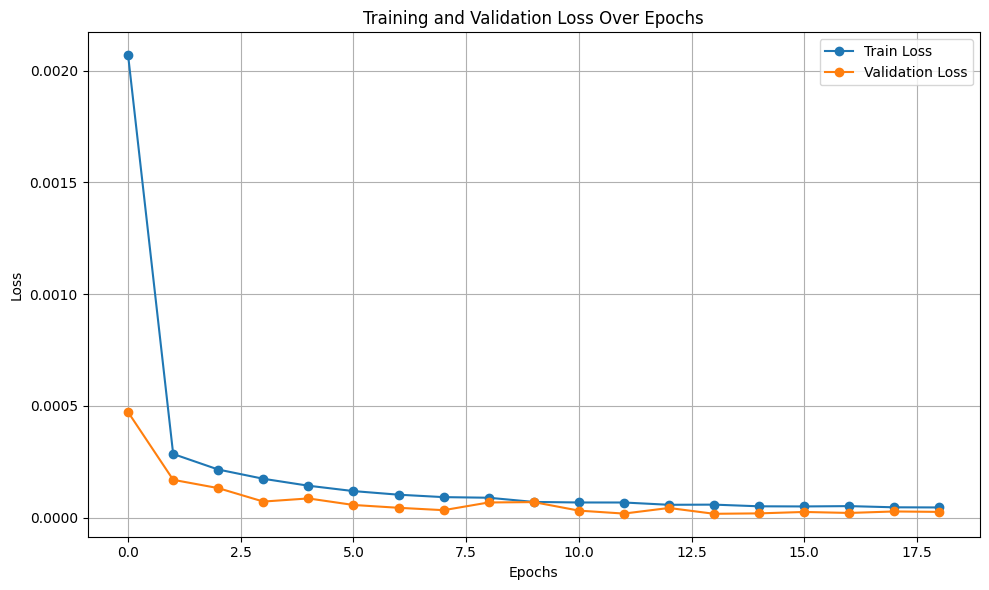

In [48]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing

In [29]:
from sklearn.metrics import mean_absolute_error

# Predict
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_num, X_test_country, X_test_year).numpy().flatten()  # predicted (scaled)
    y_true_test = y_test.numpy().flatten()                                          # true (scaled)

# Inverse transform to original yield scale
y_pred_rescaled = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_true_rescaled = target_scaler.inverse_transform(y_true_test.reshape(-1, 1)).flatten()

# Calculate MAE
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
print(f"\n🧪 Test MAE: {mae:.2f}")


🧪 Test MAE: 1835.66


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate Test Loss and Test MAE

# Ensure the model is in evaluation mode
model.eval()

# Predict on the test set
with torch.no_grad():
    y_pred_test = model(X_test_num, X_test_country, X_test_year).numpy().flatten()  # predicted (scaled)
    y_true_test = y_test.numpy().flatten()                                          # true (scaled)

# Calculate Test Loss (MSE)
test_loss = mean_squared_error(y_true_test, y_pred_test)

# Calculate Test MAE
test_mae = mean_absolute_error(y_true_test, y_pred_test)

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0001
Test MAE: 0.0044


In [31]:
print("🔍 Prediction range:", y_pred_test.min(), "to", y_pred_test.max())
print("✅ True yield range:", y_true_test.min(), "to", y_true_test.max())

🔍 Prediction range: 0.0004918266 to 0.94505864
✅ True yield range: 0.0 to 0.739251


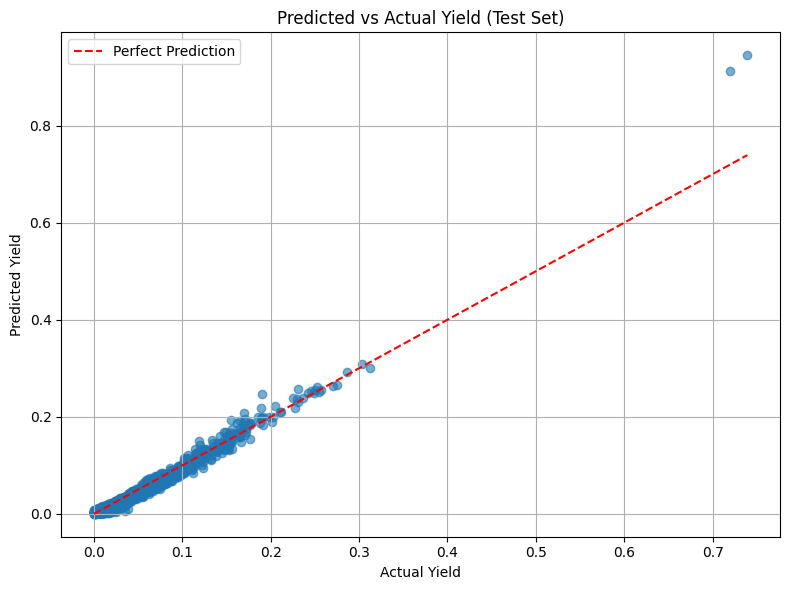

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_test, y_pred_test, alpha=0.6)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

In [34]:
# 1. Recover the item name from one-hot columns
item_cols = [col for col in test_df.columns if col.startswith('item_')]
test_df['item'] = test_df[item_cols].idxmax(axis=1).str.replace('item_', '')

# 2. Restore predictions and ground truth
test_df['yield_true'] = y_true_rescaled
test_df['yield_pred'] = y_pred_rescaled

# 3. Select clean columns for display
results_table = test_df[['year_raw', 'country', 'item', 'yield_true', 'yield_pred']]
results_table = results_table.rename(columns={'year_raw': 'year'})

# 4. Preview the output
print(results_table.head(20))

    year      country                                               item  \
0   2021  Afghanistan                                             Apples   
1   2021  Afghanistan                                           Apricots   
2   2021  Afghanistan                                             Barley   
3   2021  Afghanistan                       Cantaloupes and other melons   
4   2021  Afghanistan                                               Figs   
5   2021  Afghanistan                                             Grapes   
6   2021  Afghanistan                                            Linseed   
7   2021  Afghanistan                                       Maize (corn)   
8   2021  Afghanistan                                             Millet   
9   2021  Afghanistan                                       Mustard seed   
10  2021  Afghanistan                                             Olives   
11  2021  Afghanistan                                            Oranges   
12  2021  Af

/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/1416246486.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['item'] = test_df[item_cols].idxmax(axis=1).str.replace('item_', '')
/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/1416246486.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['yield_true'] = y_true_rescaled
/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/1416246486.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [35]:
results_table.to_csv("yield_predictions.csv", index=False)
print("✅ Results saved to 'yield_predictions.csv'")

✅ Results saved to 'yield_predictions.csv'


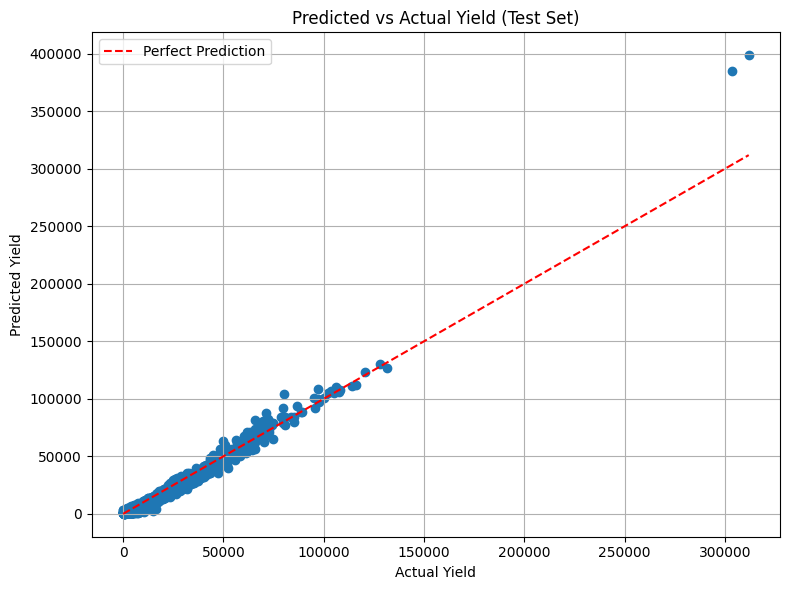

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_rescaled, y_pred_rescaled)
plt.plot([y_true_rescaled.min(), y_true_rescaled.max()],
         [y_true_rescaled.min(), y_true_rescaled.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
test_df['yield_true'] = y_true_rescaled
test_df['yield_pred'] = y_pred_rescaled

from sklearn.metrics import mean_absolute_error

year_mae = test_df.groupby('year_raw').apply(
    lambda x: mean_absolute_error(x['yield_true'], x['yield_pred'])
).reset_index(name='mae')

/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_54600/1397942013.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_mae = test_df.groupby('year_raw').apply(


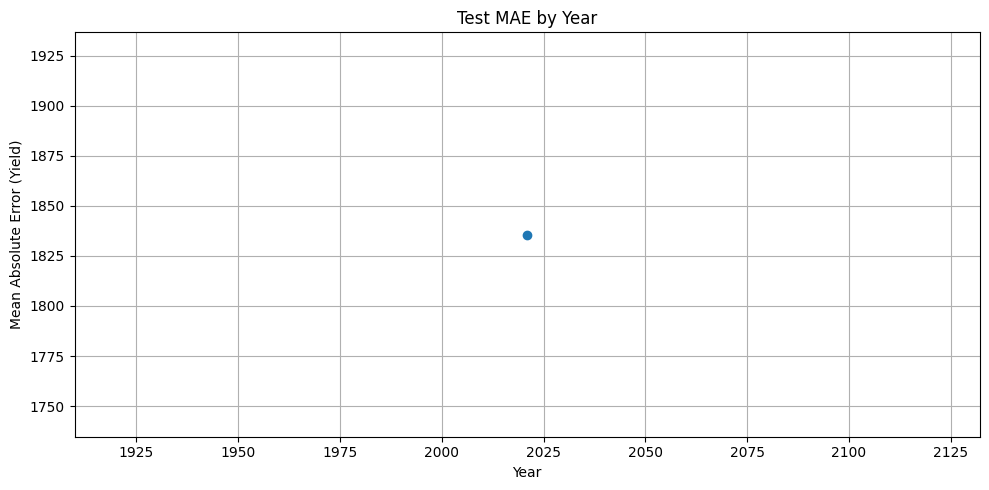

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(year_mae['year_raw'], year_mae['mae'], marker='o', linestyle='-')
plt.title("Test MAE by Year")
plt.xlabel("Year")
plt.ylabel("Mean Absolute Error (Yield)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
year_counts = test_df['year_raw'].value_counts().sort_index()
year_mae['count'] = year_counts.values
print(year_mae)

   year_raw          mae  count
0      2021  1835.662964   5169


In [40]:
import numpy as np
import pandas as pd

errors = np.abs(y_pred_rescaled.flatten() - y_true_rescaled.flatten())
top_outliers_idx = np.argsort(errors)[-2:]  # indices of top 2 worst predictions

# Print the values for inspection
for idx in top_outliers_idx:
    print(f"[{idx}] Actual: {y_true_rescaled[idx]:,.0f}, Predicted: {y_pred_rescaled[idx]:,.0f}, Error: {errors[idx]:,.0f}")

[2032] Actual: 303,615, Predicted: 384,982, Error: 81,367
[1447] Actual: 311,814, Predicted: 398,623, Error: 86,809


In [41]:
df_errors = pd.DataFrame({
    "actual": y_true_rescaled,
    "predicted": y_pred_rescaled,
    "error": errors,
    "country": test_df["country"].values,
    "item": test_df["item"].values,
    "year": test_df["year_raw"].values
})
print(df_errors.sort_values("error", ascending=False).head(2))

           actual     predicted        error             country         item  \
1447  311814.3125  398623.46875  86809.15625  Dominican Republic  Watermelons   
2032  303614.8750  384981.53125  81366.65625              Guyana      Papayas   

      year  
1447  2021  
2032  2021  
